# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [48]:
# Load pickled data
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas
import tensorflow as tf
import cv2
import time
import random
%matplotlib inline
# TODO: Fill this in based on where you saved the training and testing data

training_file = './traffic-signs-data/train.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
X_train_original, y_train_original = train['features'], train['labels']
X_test_original, y_test_original = test['features'], test['labels']
print ('Training data loaded.', X_train_original.shape, y_train_original.shape)
print ('Testing data loaded.', X_test_original.shape, y_test_original.shape)

Training data loaded. (39209, 32, 32, 3) (39209,)
Testing data loaded. (12630, 32, 32, 3) (12630,)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [49]:
### Replace each question mark with the appropriate value.

n_train = X_train_original.shape[0]

n_test = X_test_original.shape[0]

image_shape = X_train_original.shape[1:4]

unique, unique_counts = np.unique(y_train_original, return_counts=True)
n_classes = unique.shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

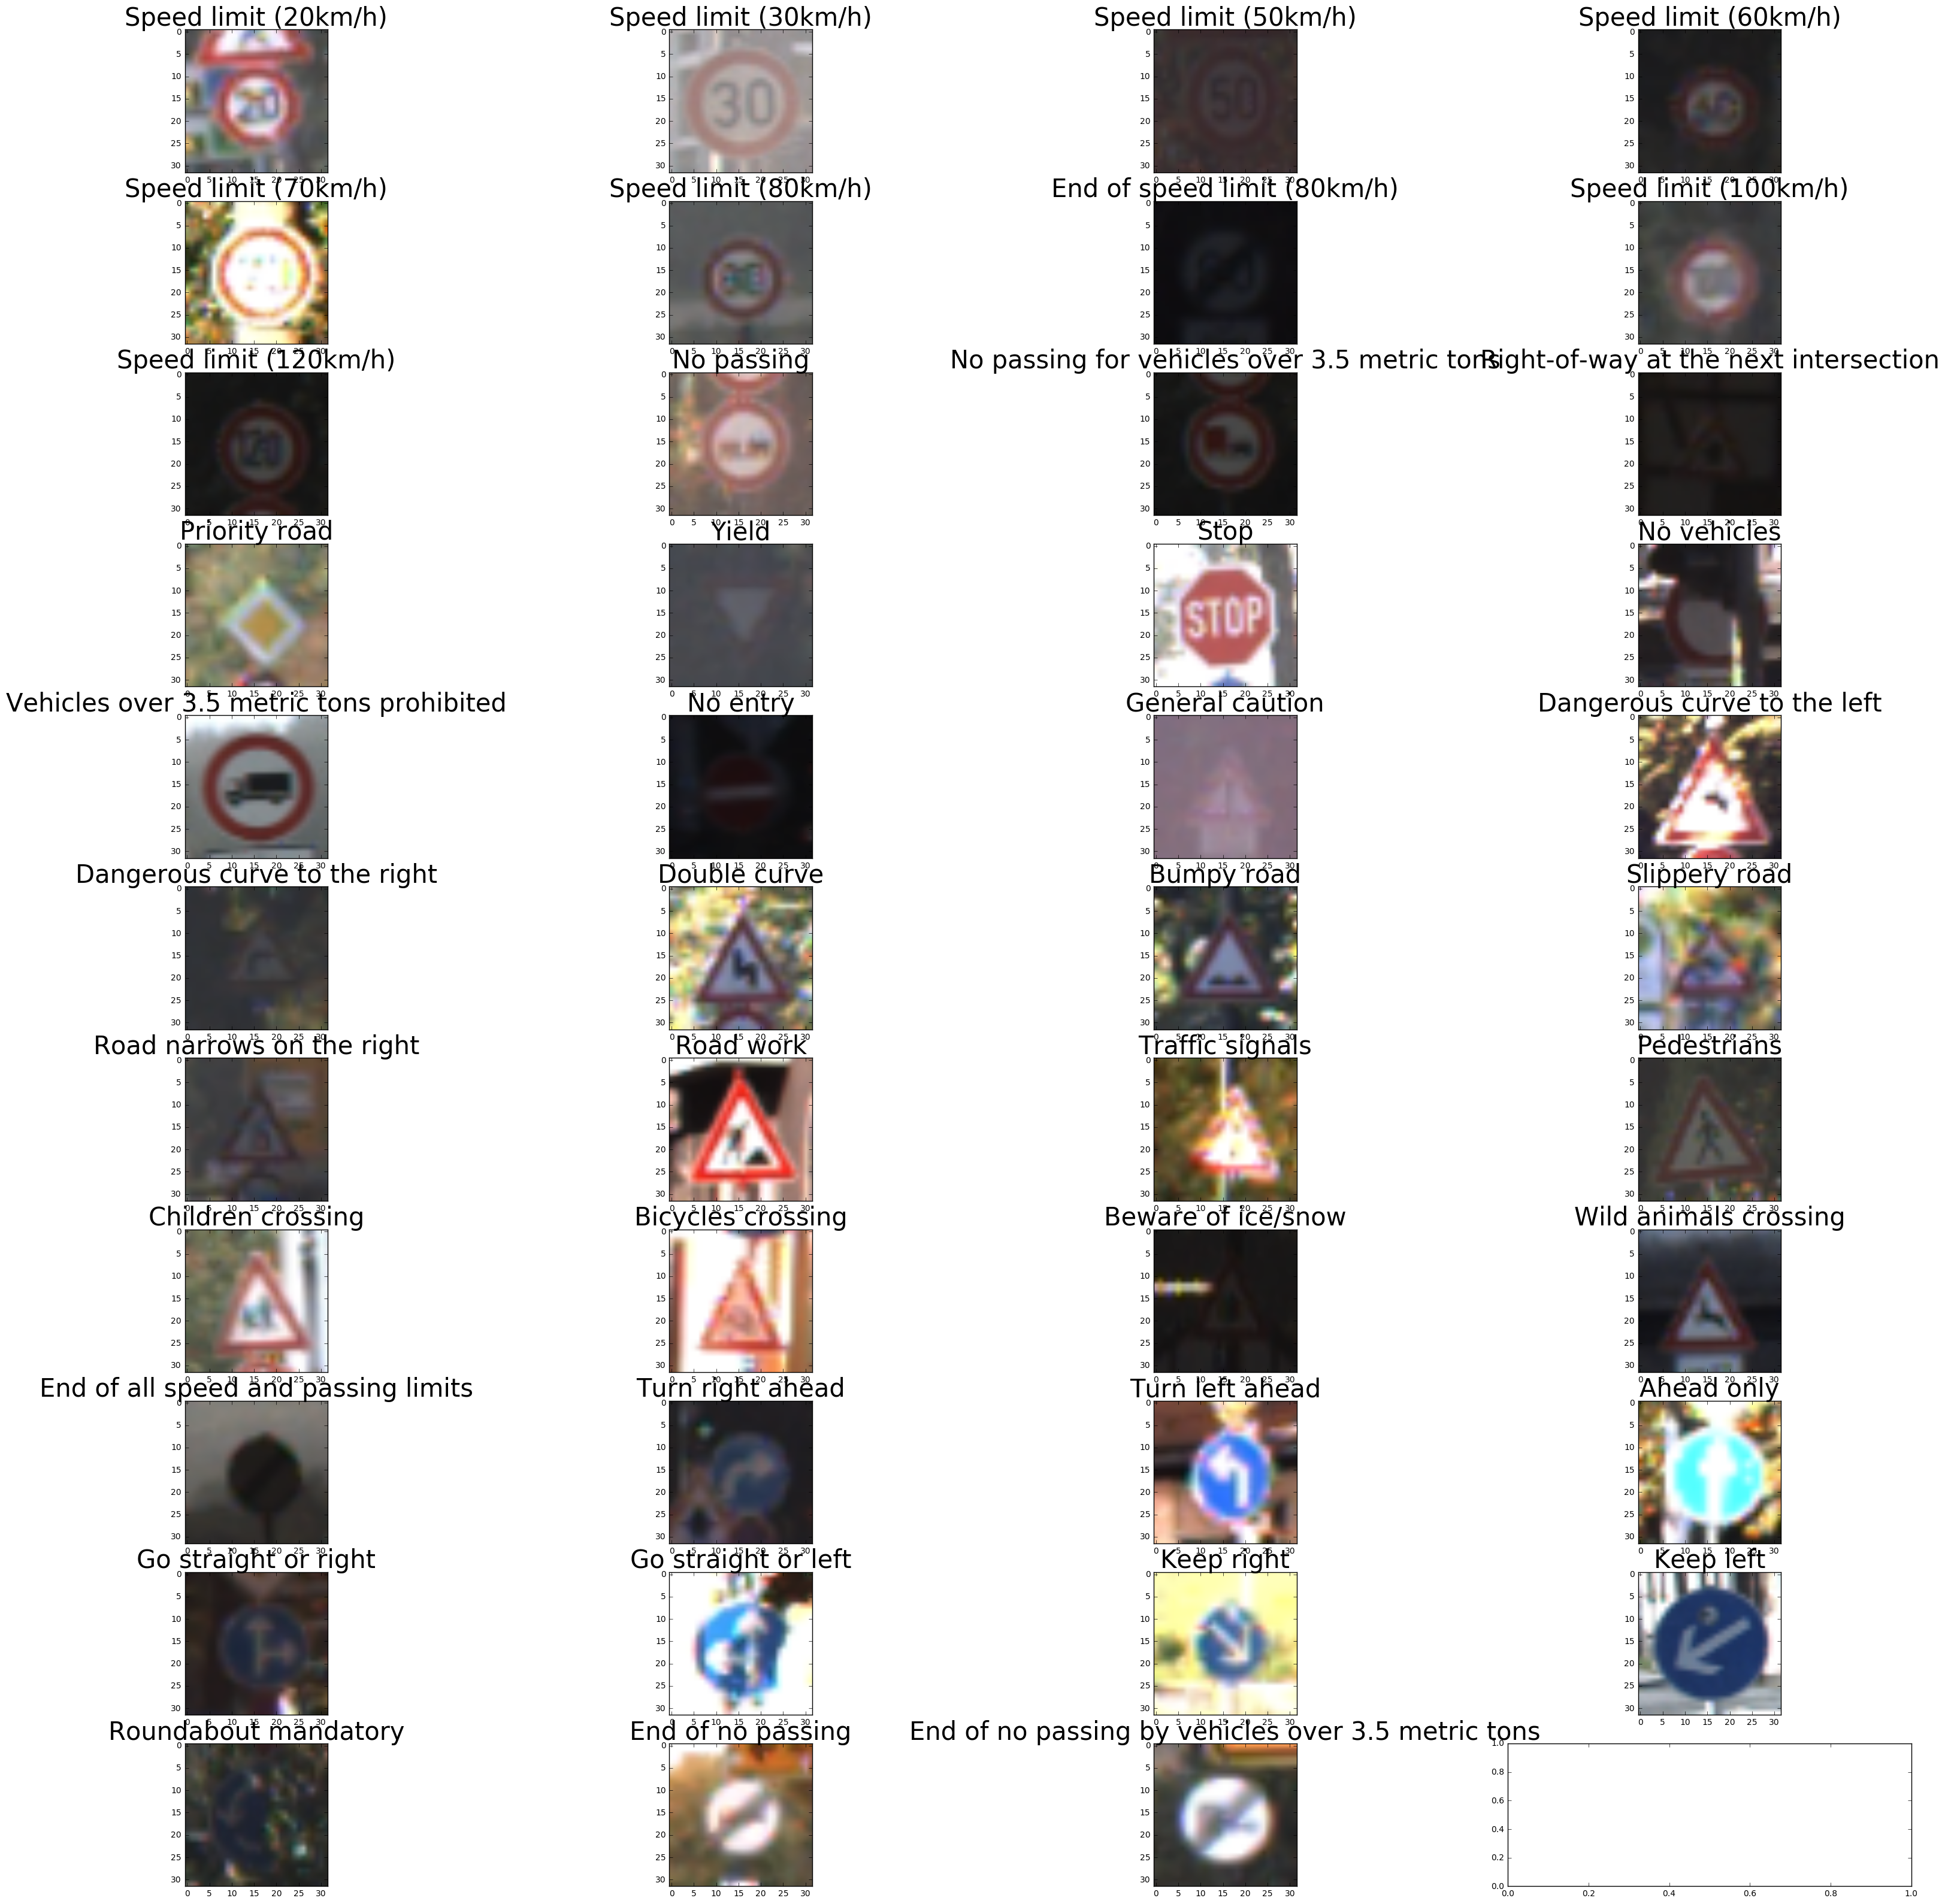

In [50]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

# Visualizations will be shown in the notebook.
#print an image for each label
signnames = pandas.read_csv('signnames.csv')
fig, ax = plt.subplots(11,4, figsize=[40,40])
for ClassId, SignName in zip(signnames.ClassId, signnames.SignName):
    image = X_train_original[np.argwhere(y_train_original == ClassId)[0][0]]
    row = int(ClassId/4)
    col = ClassId%4
    ax[row,col].imshow(image)
    ax[row,col].set_title(SignName,fontsize=30)

In [51]:
# print signnames and their counts
signnames['count'] = unique_counts
signnames

ClassId                                           SignName  count
0         0                               Speed limit (20km/h)    210
1         1                               Speed limit (30km/h)   2220
2         2                               Speed limit (50km/h)   2250
3         3                               Speed limit (60km/h)   1410
4         4                               Speed limit (70km/h)   1980
5         5                               Speed limit (80km/h)   1860
6         6                        End of speed limit (80km/h)    420
7         7                              Speed limit (100km/h)   1440
8         8                              Speed limit (120km/h)   1410
9         9                                         No passing   1470
10       10       No passing for vehicles over 3.5 metric tons   2010
11       11              Right-of-way at the next intersection   1320
12       12                                      Priority road   2100
13       13                                              Yield   2160
14       14                                               Stop    780
15       15                                        No vehicles    630
16       16           Vehicles over 3.5 metric tons prohibited    420
17       17                                           No entry   1110
18       18                                    General caution   1200
19       19                        Dangerous curve to the left    210
20       20                       Dangerous curve to the right    360
21       21                                       Double curve    330
22       22                                         Bumpy road    390
23       23                                      Slippery road    510
24       24                          Road narrows on the right    270
25       25                                          Road work   1500
26       26                                    Traffic signals    600
27       27                                        Pedestrians    240
28       28                                  Children crossing    540
29       29                                  Bicycles crossing    270
30       30                                 Beware of ice/snow    450
31       31                              Wild animals crossing    780
32       32                End of all speed and passing limits    240
33       33                                   Turn right ahead    689
34       34                                    Turn left ahead    420
35       35                                         Ahead only   1200
36       36                               Go straight or right    390
37       37                                Go straight or left    210
38       38                                         Keep right   2070
39       39                                          Keep left    300
40       40                               Roundabout mandatory    360
41       41                                  End of no passing    240
42       42  End of no passing by vehicles over 3.5 metric ...    240

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [167]:
## Transfor image

def transform(img,ang_range,shear_range,trans_range):
    """
    # I am using the image transformation code provided by Vivek Yadav 
    see https://carnd-forums.udacity.com/questions/10322627/project-2-unbalanced-data-generating-additional-data-by-jittering-the-original-image#
    """
    # Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2
                                                                                                                                                                                                                                                                                                                                                                                                                
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img

### Image jittering
MIN_FEATURE_PER_LABEL = 600 # generate additional images to have at least N_FEATURE_PER_LABEL images per label
offset = 0
label_feature = {} # Re-organize features, labels to a dict {"label1":[feature_list]}
for label, n in zip(unique, unique_counts):
    label_feature[label] = X_train_original[offset:offset+n].tolist()
    for i in range(0, MIN_FEATURE_PER_LABEL-n):
        img = X_train_original[offset+int(n*random.random())] # pick a random picture for this label
        label_feature[label].append(transform(img,20,10,5))
    
    offset += n

# transform label_feature dict to feature and label lists
labels_train = []
features_train = []
for label,features in label_feature.items():
    features_train += features
    labels_train += [label]*len(features)
print('Done!')

Done!


In [168]:
def rgb2yuv(images):
    yuv_images = []
    for image in images:
        yuv_images.append(cv2.cvtColor(image, cv2.COLOR_RGB2YUV))
    return np.array(yuv_images)
def get_normalized_y_channel(images):
    """
    get only the Y channel from a YUV image
    normalize image to the range of [low, high]
    """
    low = 0
    high = 1
    images = images[:,:,:,0].astype(np.float32)# get only the Y from YUV
    normalized_images = []
    for image in images:
        minumum = np.amin(image)
        maximum = np.amax(image)
        scale = (high-low)/(maximum-minumum)
        normalized_image = low + (image-minumum)*scale
        normalized_images.append(normalized_image)
        
    normalized_images = np.array(normalized_images)
    return np.reshape(normalized_images, normalized_images.shape+(1,))  

X_test_preprocessed = rgb2yuv(X_test_original)
X_test_preprocessed = get_normalized_y_channel(X_test_preprocessed)
features_train = np.uint8(np.array(features_train))
labels_train = np.array(labels_train)
features_train = rgb2yuv(features_train)
features_train = get_normalized_y_channel(features_train)
print('Dataset preprocessed!')

Dataset preprocessed!


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
A few papers/discussions I read suggest that RGB color space often gives the best result. John Chen in [this discussion](https://carnd-forums.udacity.com/questions/10322627/project-2-unbalanced-data-generating-additional-data-by-jittering-the-original-image#) said he used the Y component of the YUV image. I tried both RGB and YUV and I also found that the YUV gave me better results. Moreover, having only the Y component reduces the training time.

I think using Y component makes a lot of sense because the color does not really matter too much and the Y component already captures the most useful features to determine what a traffic sign is.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_


**Answer:**
Looking at the training data set, the number of example per label vary from ~200 to ~2000. I used the image transformation code provided by Vivek Yadav in [this post](https://carnd-forums.udacity.com/questions/10322627/project-2-unbalanced-data-generating-additional-data-by-jittering-the-original-image#). For example, if label0 has 200 examples and we want to generate another 200 examples, we can randomly pick an existing example and get a jiterred image. Then repeat this 200 times. After generating additional images, the new training dataset are more "balanced" and therefore the bias of the trained model should be reduced. 

**Testing data**: I use the original test data set

**Training/validation dataset**: 
First I generated some additional data to the traning dataset. Then I used the train_test_split function from sklearn to split the new training dataset to training and validation datasets. The ratio is 90/10. Also, I do shuffling and train/validation split during each training epoch.


In [145]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

def conv2d(x, weight_shape, padding, stride=1, mu=0, sigma=0.1):
    depth = weight_shape[3]
    weights = tf.Variable(tf.truncated_normal(shape=weight_shape, mean=mu, stddev=sigma))
    biases = tf.Variable(tf.zeros(depth))
    layer = tf.nn.conv2d(x, weights, strides=[1,stride,stride,1], padding=padding)
    layer = tf.nn.bias_add(layer, biases)
    return tf.nn.relu(layer)
#fully-connected layer
def fc(x, output_size, use_activation=True, mu=0, sigma=0.1):
    shape = (x.get_shape().as_list()[1], output_size)
    weights = tf.Variable(tf.truncated_normal(shape=shape, mean=mu, stddev=sigma))
    biases = tf.Variable(tf.zeros(output_size))
    logits = tf.add(tf.matmul(x, weights), biases)
    if use_activation:
        logits = tf.nn.relu(logits)
        
    return logits

def flatten(x):
    shape = x.get_shape()
    size = int(shape[1]*shape[2]*shape[3])
    return tf.reshape(x, [-1,size])

def LeNet(x, keep_prob):        
    # Layer 1: Convolutional. 
    d1 = 16
    n_channel = int(x.get_shape()[3])
    conv1 = conv2d(x, (5,5,n_channel,d1), 'SAME')
    conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    # Layer 2: Convolutional. 
    d2 = 32
    conv2 = conv2d(conv1, (5,5,d1,d2), 'VALID')
    conv2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    # Flatten.
    flat = flatten(conv2)

    # Layer 3: Fully Connected. 
    fc1 = fc(flat, 300)

    # Layer 4: Fully Connected. 
    fc2 = fc(fc1, 84)
    fc2 = tf.nn.dropout(fc2, keep_prob=keep_prob)

    # Layer 5: Fully Connected. 
    fc3 = fc(fc2, n_classes, False)
    return fc3

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

I used the same architecture as the LeNet in this course. I slightly modified some parameters. For example, I increased the depth of the conv layers as well as the size of fully connected layers. Also, I implemented dropout to avoid overfitting.

The architecture is: ConvLayer1->ConvLayer2->Flatten->FullyConnectedLayer1->FullyConnectedLayer2->OutputLayer

In [160]:
### Train your model here.
### Feel free to use as many code cells as needed.
EPOCHS = 30
BATCH_SIZE = 32
LEANRING_RATE = 0.001

tf.reset_default_graph()

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)

logits = LeNet(x, keep_prob)
loss = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(loss)
optimizer = tf.train.AdamOptimizer(learning_rate = LEANRING_RATE)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()
init = tf.global_variables_initializer()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [161]:
# Training
with tf.Session() as session:
    session.run(init)
    for i in range(0, EPOCHS):  
        before = time.time()
        features_train, labels_train = shuffle(features_train, labels_train)
        X_train, X_validation, y_train, y_validation = train_test_split(features_train, labels_train, test_size=0.1)
        for offset in range(0, len(X_train), BATCH_SIZE):
            batch_x, batch_y = X_train[offset:offset+BATCH_SIZE], y_train[offset:offset+BATCH_SIZE]
            session.run(training_operation, feed_dict={x:batch_x, y:batch_y, keep_prob:0.6})

        validation_accuracy = evaluate(X_validation, y_validation)
        print("Time consumed: ", int(time.time()-before))
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    print("test Accuracy = {:.3f}".format(evaluate(X_test_preprocessed, y_test_original)))
    saver.save(session, 'project2')
    print("Model saved.")

Time consumed:  42
EPOCH 1 ...
Validation Accuracy = 0.880

Time consumed:  39
EPOCH 2 ...
Validation Accuracy = 0.926

Time consumed:  40
EPOCH 3 ...
Validation Accuracy = 0.939

Time consumed:  43
EPOCH 4 ...
Validation Accuracy = 0.955

Time consumed:  44
EPOCH 5 ...
Validation Accuracy = 0.956

Time consumed:  45
EPOCH 6 ...
Validation Accuracy = 0.974

Time consumed:  41
EPOCH 7 ...
Validation Accuracy = 0.981

Time consumed:  40
EPOCH 8 ...
Validation Accuracy = 0.979

Time consumed:  42
EPOCH 9 ...
Validation Accuracy = 0.984

Time consumed:  42
EPOCH 10 ...
Validation Accuracy = 0.984

Time consumed:  43
EPOCH 11 ...
Validation Accuracy = 0.989

Time consumed:  43
EPOCH 12 ...
Validation Accuracy = 0.989

Time consumed:  50
EPOCH 13 ...
Validation Accuracy = 0.994

Time consumed:  54
EPOCH 14 ...
Validation Accuracy = 0.993

Time consumed:  44
EPOCH 15 ...
Validation Accuracy = 0.994

Time consumed:  44
EPOCH 16 ...
Validation Accuracy = 0.994

Time consumed:  44
EPOCH 17 ...
V

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_



**Answer:**
* Optimizer: AdamOptimizer. Tried to use GradientDescentOptimizer as well but it did not produce satisfying results.
* Batch size: 32. I tried batch size 256, 128, 64 and 32 and found that 32 gave the best result.
* Epochs: After some trial and error I found the test accuracy converges after ~30 epochs so chose 30.
* Hyperparameters: use mu=0, sigma=0.1 for generating truncated normal distribution to initialize weights.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I devided this problem into several steps: preprocessing -> network model -> model architecture -> parameters -> regularization/pooling -> activation 

I tried to use both RGB and Y component of YUV and the latter gave me the best results. 

Since we are working on an image classification problem, I found CNN is the most popular choice and that's what I choose.

I decided to use similar CNN architecture with the LeNet in this course. 

For training parameters, I started with a 0.001 learning rate and it worked well. Tried to increase it and the results became worse. I chose the epochs and batch size based on trial and error.

I used 2X2 max pooling. I also used dropout with keep_prob=0.6 to avoid overfitting.

In the [Must Know Tips/Tricks in Deep Neural Networks](http://lamda.nju.edu.cn/weixs/project/CNNTricks/CNNTricks.html), the author suggests relu is one of the best activation functions. I decided to use relu as well. 

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

['.DS_Store', 'NoEntry.png', 'RoadWork.png', 'SpeedLimit60.png', 'Stop.png', 'WildAnimal.jpg', 'Yield.png']


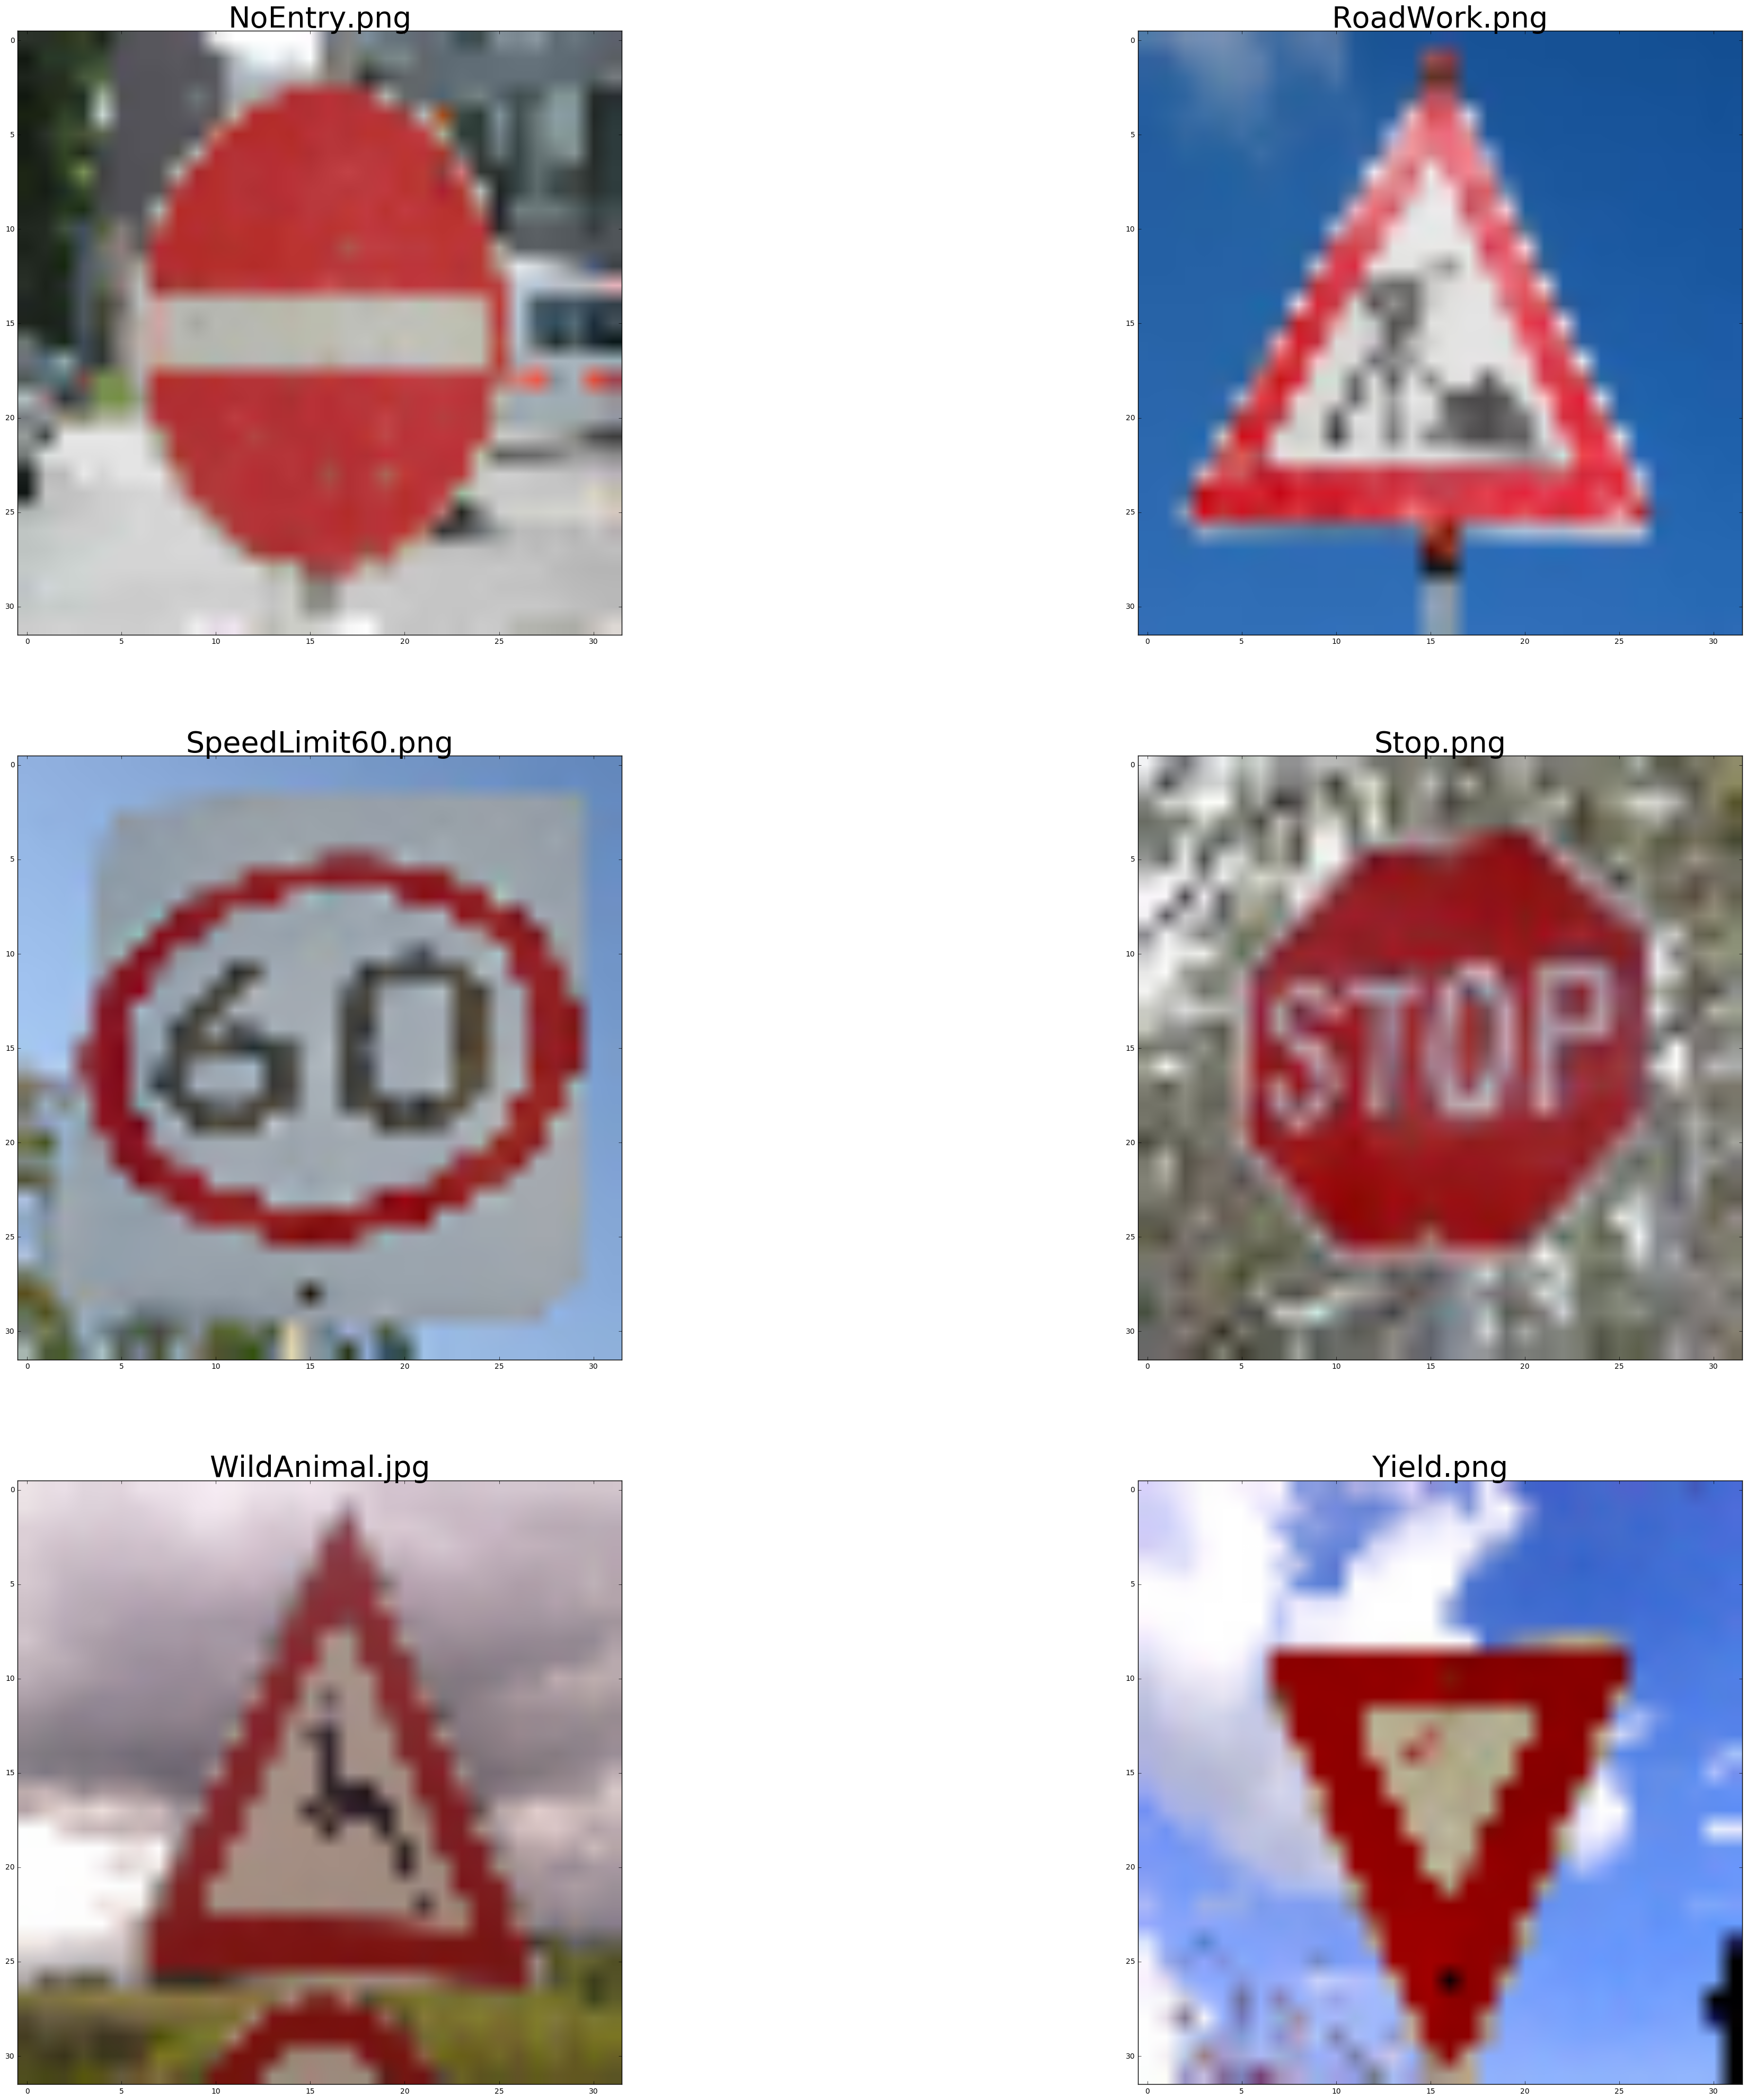

In [157]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os
import matplotlib.image as mpimg

def load_and_resize(files):
    resized_images = []
    fig, ax = plt.subplots(3,2, figsize=[50,50])
    for i in range(len(files)):
        image = mpimg.imread(folder + files[i])
        row = int(i/2)
        col = i%2
        resized = cv2.resize(image, (32,32))
        resized_images.append(resized)
        ax[row,col].imshow(resized)
        ax[row,col].set_title(files[i],fontsize=40)

    return np.array(resized_images)

folder = 'new-data/'
files = os.listdir(folder)
print(files)
files.remove('.DS_Store')# remove the annoying auto generated file

resized_images = load_and_resize(files)

# preprocess the images
processed_images = rgb2yuv(resized_images)
processed_images = get_normalized_y_channel(processed_images)
labels = np.array([17,25,3,14,31,13])

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
The images I chose are fairly clear for human to classify. However, in terms of machine learning, a few images have some complex background which may confuse the classifier. For example, the "NoEntry" image has a background which contains an ambulance. The lines on the ambulance may confuse the classifier as those lines have similar patterns with some of the traffic signs.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._

**Answer:**
The accuracy is 83%. It's lower than the testing accuracy on the dataset. However, since the new test dataset is also very small, failing to classify one image can significantly influence the overall accuracy. 

In [164]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
probs = tf.nn.softmax(logits)
with tf.Session() as sess:
    saver.restore(sess, './project2')
    probs_value = sess.run(probs, feed_dict={x:processed_images, keep_prob:1.0})
    values, indices = tf.nn.top_k(probs_value,k=3)
    values = values.eval()
    indices = indices.eval()
    num = labels.shape[0]
    predicted = indices[:,0]
    print('expected:', labels)
    print('prediction:',predicted)
    print('accuracy', np.sum(np.equal(labels, predicted))/num)

expected: [17 25  3 14 31 13]
prediction: [17 25  5 14 31 13]
accuracy 0.833333333333


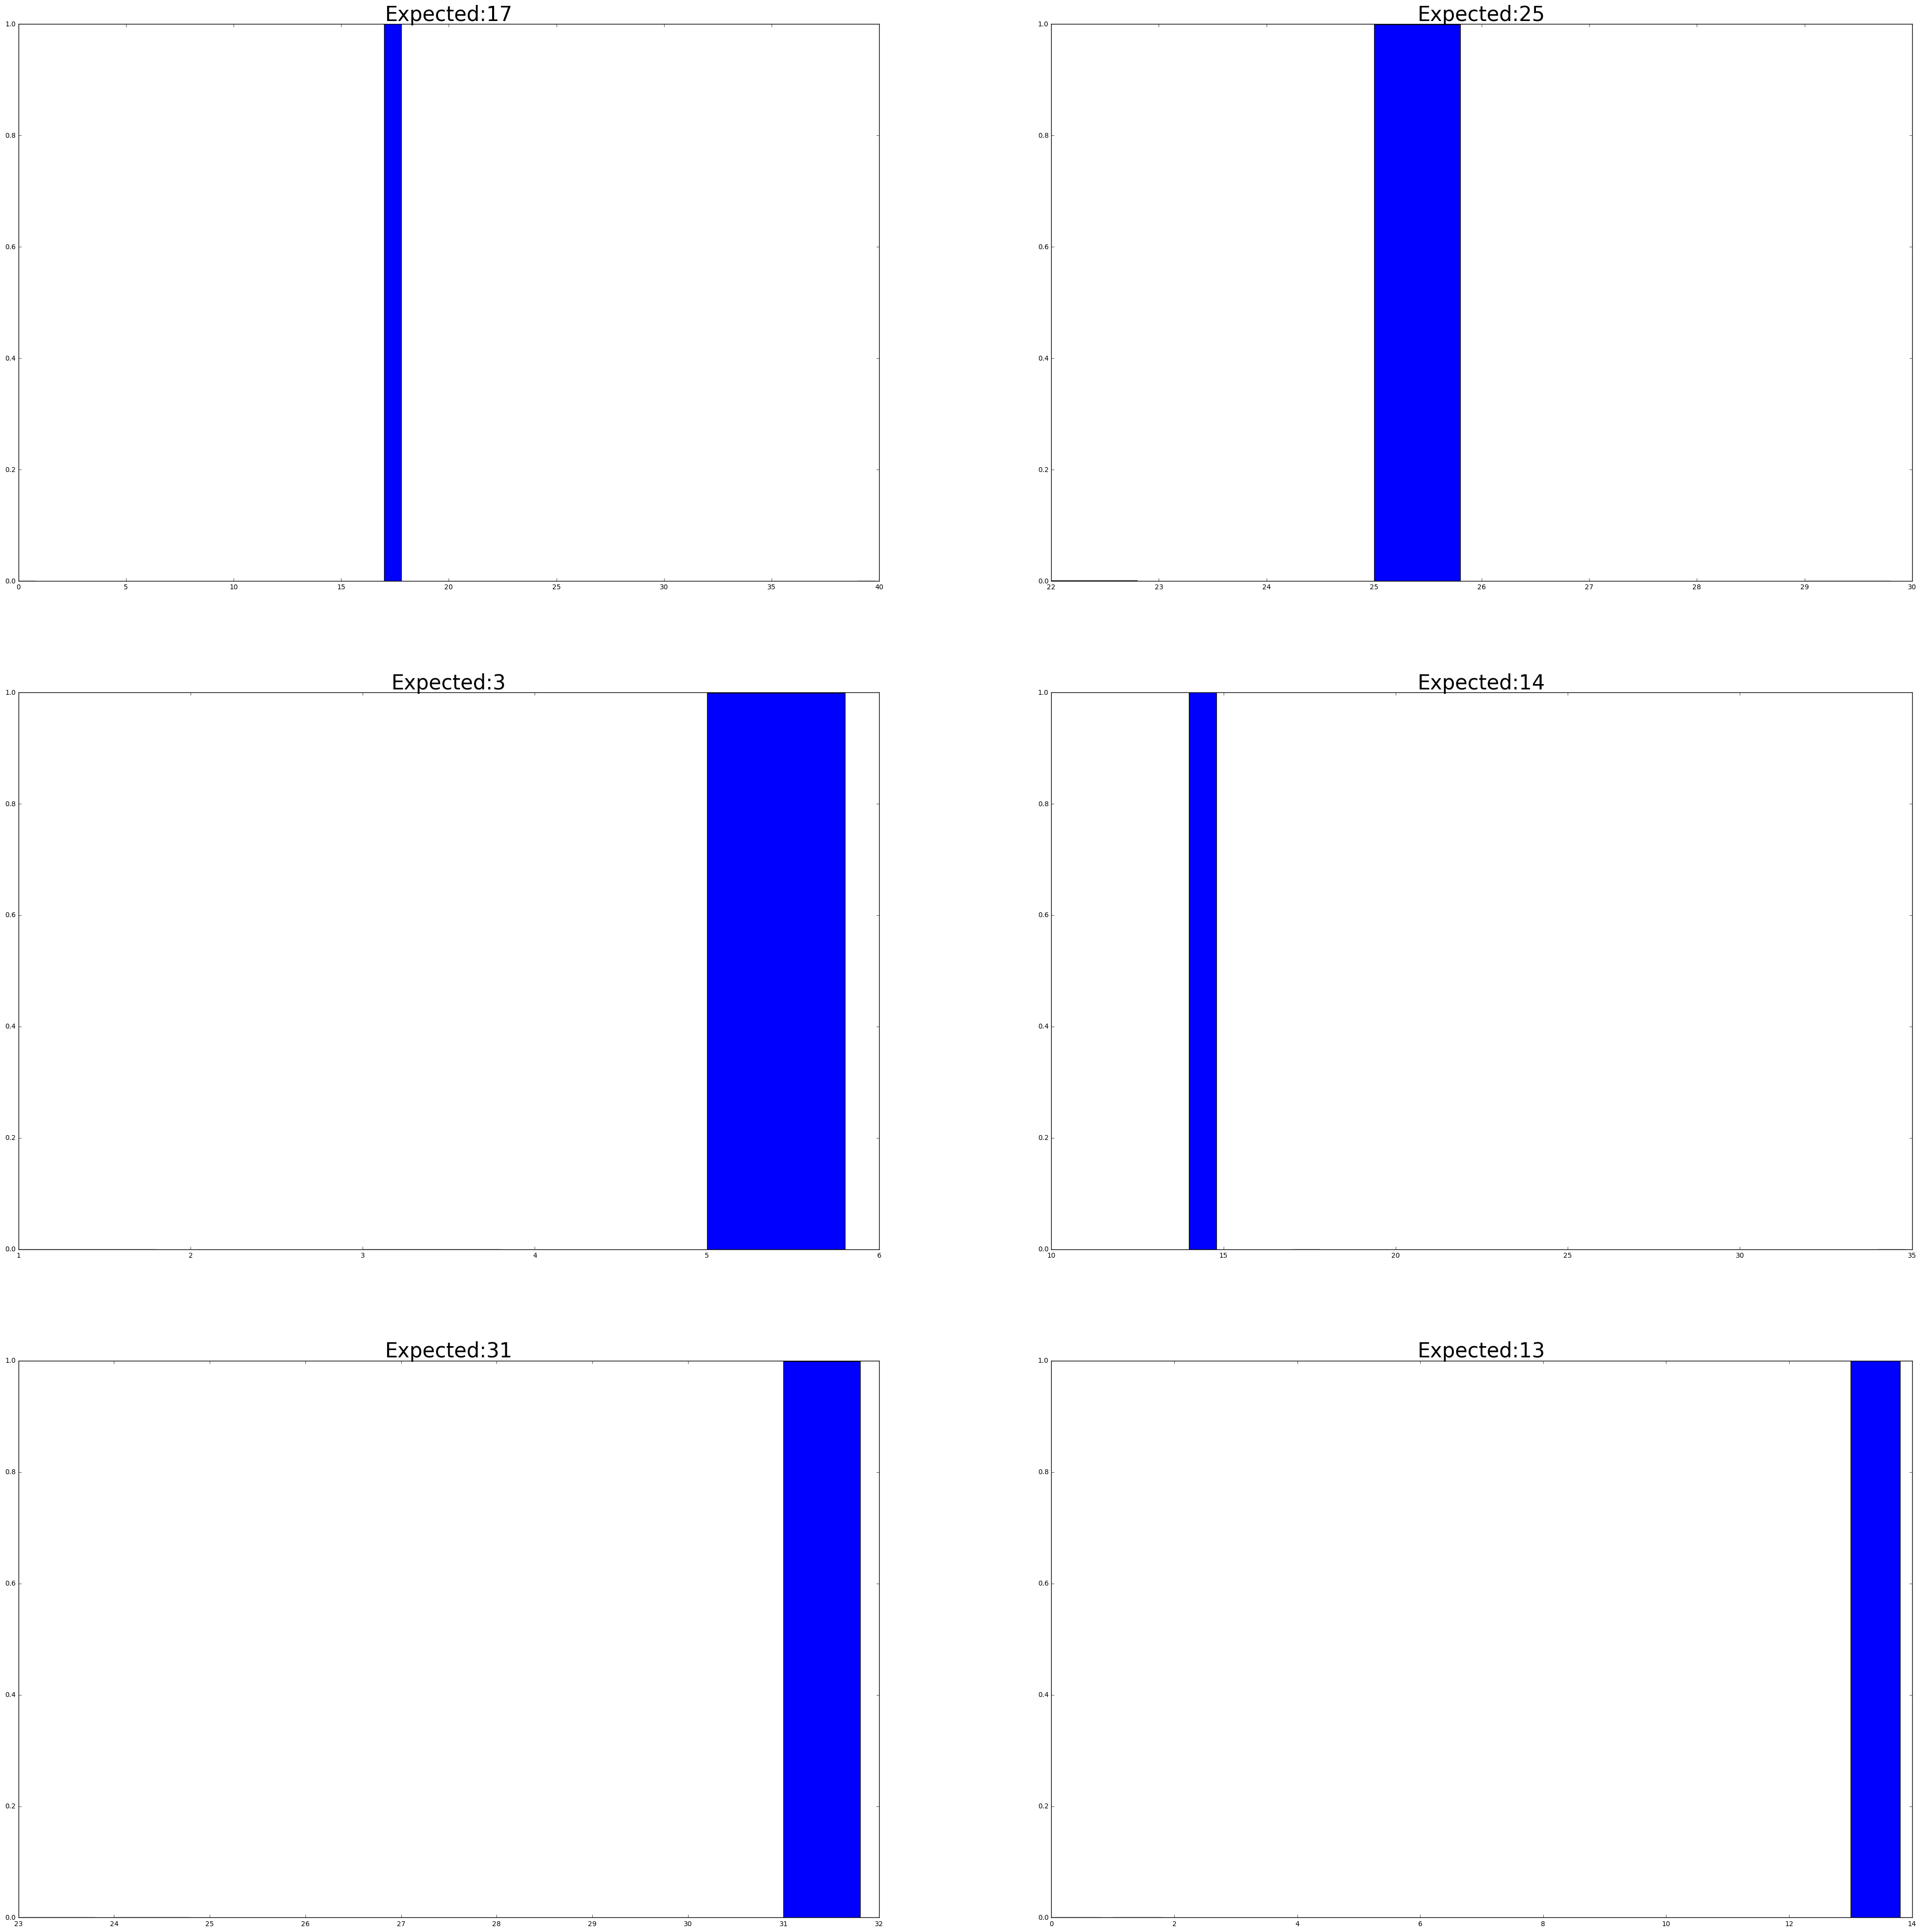

In [165]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
fig, ax = plt.subplots(3,2, figsize=[50,50])
for i in range(num):
    label = 'Expected:'+str(labels[i])
    row = int(i/2)
    col = i%2
    ax[row,col].bar(indices[i,:], values[i,:])
    ax[row,col].set_title(label, fontsize=30)

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**
The model is very certain(top1 with >99% probability) on all images. However, the classification for SpeedLimit60 is wrong. It was classified to be SpeedLimit80.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.